In [6]:
import sys
print(sys.executable)

c:\Program Files\Python311\python.exe


In [7]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.20.0
Num GPUs Available: 0


In [8]:
# Then import the required libraries
import importlib
import numpy as np
import os
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
# Remove standalone keras imports and use tf.keras instead
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# Update keras imports to use tf.keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
# Use tf.keras.models instead
from sklearn.model_selection import GridSearchCV
import joblib

In [9]:
seed = 0
np.random.seed(seed)

df = pd.read_csv('gene_level_methylation.csv')

print("Original columns:", df.columns.tolist()[:10], "...")

# Remove the "SingleValueType" column if it exists
if "SingleValueType" in df.columns:
    df = df.drop(columns=["SingleValueType"])
    print("Column 'SingleValueType' has been removed successfully.")
else:
    print("Column 'SingleValueType' does not exist in the DataFrame.")

# Sort columns and transpose
df = df.reindex(sorted(df.columns), axis=1)
df = df.T

# Set first row (originally "GeneSymbol") as new column names
df.columns = df.iloc[0]  # first row becomes column headers
df = df.drop(df.index[0])  # drop the first row

print("CNV Matrix After Transpose and Header Fix:", df.shape)
print("\nDataFrame preview:")
df.head()

Original columns: ['GeneSymbol', 'SingleValueType', 'TCGA-OL-A66H-01', 'TCGA-3C-AALK-01', 'TCGA-AC-A5EH-01', 'TCGA-EW-A2FW-01', 'TCGA-E9-A1R0-01', 'TCGA-AR-A1AJ-01', 'TCGA-AC-A62Y-01', 'TCGA-E9-A1QZ-01'] ...
Column 'SingleValueType' has been removed successfully.
CNV Matrix After Transpose and Header Fix: (888, 19277)

DataFrame preview:


GeneSymbol,RPS4Y2,RPS4Y1,TBL1Y,NLGN4Y,PRKY,PCDH11Y,TTTY20,GABRE,FTHL17,PORCN,...,EP300,DERL3,PLA2G3,TMPRSS6,MIR1281,GGT3P,UBE2L3,APOL5,SLC5A1,CDC42EP1
TCGA-3C-AAAU-01,0.527,0.57214,0.447925,0.052075,0.1233,0.0581,0.50125,0.377325,0.878033,0.365011,...,0.099,0.04835,0.7942,0.86505,0.099,0.8638,0.3368,0.928,0.1865,0.0178
TCGA-3C-AALI-01,0.6489,0.5074,0.426008,0.07245,0.8148,0.0836,0.473473,0.387325,0.758033,0.254889,...,0.0617,0.38345,0.7698,0.8228,0.0617,0.8317,0.8098,0.8742,0.8993,0.0234
TCGA-3C-AALJ-01,0.6949,0.563733,0.464233,0.0675,0.7933,0.0627,0.45565,0.333725,0.6283,0.473433,...,0.075,0.4813,0.7681,0.8433,0.075,0.7911,0.44875,0.8888,0.739,0.031
TCGA-3C-AALK-01,0.5778,0.5722,0.50945,0.34105,0.6853,0.2694,0.5769,0.53885,0.9241,0.417256,...,0.0856,0.5369,0.7532,0.83555,0.0856,0.8151,0.3113,0.9321,0.763,0.0274
TCGA-4H-AAAK-01,0.4716,0.5077,0.45365,0.063675,0.6571,0.3482,0.438033,0.480625,0.9169,0.469724,...,0.0808,0.1768,0.6704,0.7699,0.0808,0.8049,0.2855,0.937,0.7207,0.0268


In [10]:
df2=pd.read_csv('BRCA_clinicalMatrix.gz',compression='gzip',sep='\t',index_col=0)
df2.index = pd.Series({x: x.replace('-', '-') for x in df2.index})
print("Clinical Data Before:", df2.shape)
k=df2.columns.get_loc('PAM50Call_RNAseq')
df2=df2[df2.iloc[:,k].isna()==False]
df2.head()

FileNotFoundError: [Errno 2] No such file or directory: 'BRCA_clinicalMatrix.gz'

In [ ]:
commonIndexes=np.sort(list(set(df2.index).intersection(set(df.index)))) 
df=df.loc[commonIndexes] 
df2=df2.loc[commonIndexes] 
print("Data After:", df.shape) 
print("Clinical Data After:", df2.shape) 
print("CNV and Clinical Data corresponds to same Patients: ", False if False in (df.index==df2.index) else True) 
unique_elements, counts_elements = np.unique(df2.iloc[:,k], return_counts=True) 
print("Labels", unique_elements, counts_elements)

Data After: (620, 20141)
Clinical Data After: (620, 202)
CNV and Clinical Data corresponds to same Patients:  True
Labels ['Basal' 'Her2' 'LumA' 'LumB' 'Normal'] [ 87  31 288 127  87]


In [ ]:
#all genes

In [ ]:
original_feature_names = df.columns.tolist()
X=np.array(df.values, dtype=float)
X.shape
Y=np.array(df2.values[:,k])
Y.shape

(620,)

In [ ]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

In [ ]:
folds = list(skf.split(X, Y))

# Select fold 4
train_idx, test_idx = folds[4]
X_train, X_test = X[train_idx], X[test_idx]
Y_train, Y_test = Y[train_idx], Y[test_idx]

X_train.shape, X_test.shape

((496, 20141), (124, 20141))

In [ ]:
# Define features (X) and labels (y)
X = df.values.astype(float)    # features must be numeric
y = df2.iloc[:, k].values      # PAM50 labels
original_feature_names = df.columns.tolist()

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)
print("Classes:", np.unique(y))

Feature matrix shape: (620, 20141)
Labels shape: (620,)
Classes: ['Basal' 'Her2' 'LumA' 'LumB' 'Normal']


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from scikeras.wrappers import KerasClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from tensorflow.keras.optimizers import Adam
import time
import pandas as pd

# Split data FIRST
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

# Label encode
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Get number of classes and input dimension
n_classes = len(np.unique(y_train_enc))
input_dim = X_train.shape[1]

print(f"Input dimensions: {input_dim}")
print(f"Number of classes: {n_classes}")

# Create function to build neural network with more options
def create_nn(meta, neurons_layer1=256, neurons_layer2=128, dropout_rate=0.3, 
              learning_rate=0.002, activation='relu', regularization=None):
    
    # Set regularizer
    if regularization == 'l1':
        reg = l1(1e-15)
    elif regularization == 'l2':
        reg = l2(1e-15)
    elif regularization == 'l1_l2':
        reg = l1_l2(l1=1e-15, l2=1e-15)
    else:
        reg = None

    # Get input dimensions from meta
    n_features_in = meta["n_features_in_"]
    n_classes = meta["n_classes_"]
    
    # Build model
    model = Sequential([
        Dense(neurons_layer1, activation=activation, kernel_regularizer=reg, 
              input_shape=(n_features_in,)),  # Adjust based on feature selection
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(neurons_layer2, activation=activation, kernel_regularizer=reg),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(n_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap model
nn_model = KerasClassifier(
    model=create_nn, 
    epochs=100, 
    batch_size=16, 
    verbose=0,
    callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
)

# Pipeline with feature selection
pipeline = ImbPipeline([
    ('scaler', MinMaxScaler()),
    #('feature_selection', SelectKBest(f_classif, k=500)),  # Speeds up training
    ('irus', RandomUnderSampler(random_state=seed)),
    ('nn', nn_model)
])

# Parameter grid based on the paper
param_grid = {
    # Best from paper: None, ReLU, 0.002, 16, 0.3
    'nn__model__regularization': [None, 'l1', 'l2', 'l1_l2'],
    'nn__model__activation': ['relu', 'tanh', LeakyReLU(negative_slope=0.01)],
    'nn__model__learning_rate': [0.01, 0.002, 0.001, 0.0001, 0.00001, 0.000001],
    'nn__batch_size': [16, 32, 64, 128],
    'nn__model__dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    #'nn__model__neurons_layer1': [128, 256],  # Not in paper but good to test
    #'nn__model__neurons_layer2': [64, 128]
}

# Use RandomizedSearchCV to sample combinations
print("Starting hyperparameter search...")
print(f"Total possible combinations: {4 * 3 * 6 * 4 * 5 * 2 * 2} = {4*3*6*4*5*2*2}")
print("Testing 50 random combinations with 3-fold CV = 150 model trainings\n")

start_time = time.time()

grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50,  # Test 50 random combinations
    cv=2,  # 3-fold CV (paper uses 5-fold, but 3 is faster)
    scoring='f1_weighted',
    n_jobs=1,  # Use 1 to avoid issues with Keras
    verbose=3,  # Maximum verbosity for progress tracking
    random_state=seed,
    return_train_score=True
)

# Fit with progress tracking
grid_search.fit(X_train, y_train_enc)

end_time = time.time()
elapsed_time = (end_time - start_time) / 60  # Convert to minutes

# Results
print("\n" + "="*80)
print("SEARCH COMPLETE!")
print("="*80)
print(f"\nTotal time: {elapsed_time:.2f} minutes")
print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")

# Test on held-out test set
test_acc = grid_search.score(X_test, y_test_enc)
print(f"Test set accuracy: {test_acc:.4f}")

# Create results dataframe
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')

# Show top 10 configurations
print("\n" + "="*80)
print("TOP 10 CONFIGURATIONS:")
print("="*80)
top_10 = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)
for idx, row in top_10.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    print(f"  Accuracy: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"  Parameters: {row['params']}")

# Save results to CSV
results_df.to_csv('nn_hyperparameter_search_results.csv', index=False)
print("\n" + "="*80)
print("Full results saved to 'nn_hyperparameter_search_results.csv'")
print("="*80)

d:\Program Files\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Program Files\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Input dimensions: 19277
Number of classes: 5
Starting hyperparameter search...
Total possible combinations: 5760 = 5760
Testing 50 random combinations with 3-fold CV = 150 model trainings

Fitting 2 folds for each of 50 candidates, totalling 100 fits


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.001, nn__model__regularization=l2;, score=(train=0.772, test=0.738) total time=  49.9s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.001, nn__model__regularization=l2;, score=(train=0.679, test=0.651) total time=  36.6s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.043, test=0.035) total time=   9.9s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.295, test=0.294) total time=  10.0s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.125, test=0.123) total time=  19.3s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.569, test=0.545) total time=  29.4s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.274, test=0.286) total time=  32.5s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.454, test=0.448) total time=  51.9s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.708, test=0.688) total time= 1.4min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.606, test=0.539) total time= 1.4min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.687, test=0.589) total time=  47.8s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.598, test=0.620) total time=  58.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate=0.3, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.489, test=0.462) total time=  25.5s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate=0.3, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.479, test=0.431) total time=  32.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.779, test=0.699) total time=  39.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.656, test=0.682) total time= 1.1min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.394, test=0.343) total time=  21.3s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.294, test=0.240) total time=  35.1s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l1_l2;, score=(train=0.109, test=0.117) total time=  14.8s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l1_l2;, score=(train=0.404, test=0.387) total time=  30.3s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.744, test=0.677) total time=  23.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.667, test=0.600) total time=  33.4s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=1e-05, nn__model__regularization=l2;, score=(train=0.754, test=0.734) total time=  44.1s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=1e-05, nn__model__regularization=l2;, score=(train=0.609, test=0.615) total time=  45.7s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.294, test=0.294) total time=  18.8s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.229, test=0.228) total time=  21.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.789, test=0.734) total time=  37.4s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.699, test=0.693) total time=  44.1s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=None;, score=(train=0.809, test=0.742) total time=  32.6s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=None;, score=(train=0.571, test=0.599) total time=  35.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.764, test=0.694) total time=  34.1s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.581, test=0.478) total time=  26.3s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.298, test=0.325) total time=  20.4s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.225, test=0.215) total time=  18.4s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.004, test=0.004) total time=   9.0s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.035, test=0.035) total time=   8.9s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l2;, score=(train=0.035, test=0.035) total time=   9.3s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l2;, score=(train=0.070, test=0.070) total time=   9.0s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.01, nn__model__regularization=l1;, score=(train=0.070, test=0.070) total time=  14.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.01, nn__model__regularization=l1;, score=(train=0.004, test=0.004) total time=   9.1s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.816, test=0.757) total time=  49.7s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.681, test=0.669) total time= 1.1min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.771, test=0.727) total time=  56.0s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.673, test=0.677) total time=  54.6s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.766, test=0.717) total time=  44.3s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.388, test=0.464) total time=  26.1s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.421, test=0.431) total time=   9.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.004, test=0.004) total time=   9.1s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=l1;, score=(train=0.526, test=0.484) total time=  18.5s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=l1;, score=(train=0.638, test=0.636) total time=  27.9s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.808, test=0.735) total time=  32.8s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.651, test=0.674) total time=  36.7s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.667, test=0.658) total time= 1.0min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.527, test=0.533) total time= 1.0min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.035, test=0.035) total time=  21.7s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.035, test=0.035) total time=  15.6s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.326, test=0.277) total time=  23.1s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.287, test=0.278) total time=  11.6s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.070, test=0.070) total time=  40.0s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.083, test=0.080) total time=  24.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.625, test=0.547) total time=  36.4s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.796, test=0.728) total time=  43.7s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.001, nn__model__regularization=l2;, score=(train=0.035, test=0.035) total time=  23.9s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.001, nn__model__regularization=l2;, score=(train=0.107, test=0.087) total time=  17.8s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=1e-05, nn__model__regularization=l2;, score=(train=0.755, test=0.696) total time=  28.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=1e-05, nn__model__regularization=l2;, score=(train=0.643, test=0.617) total time=  29.5s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.774, test=0.763) total time=  42.9s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.725, test=0.715) total time=  30.5s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.035, test=0.035) total time=  11.3s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.035, test=0.035) total time=  10.7s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-05, nn__model__regularization=l1;, score=(train=0.714, test=0.682) total time=  42.1s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-05, nn__model__regularization=l1;, score=(train=0.586, test=0.562) total time=  44.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=None;, score=(train=0.808, test=0.725) total time=  30.4s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=None;, score=(train=0.607, test=0.629) total time=  31.8s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.062, test=0.050) total time=  10.7s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.042, test=0.051) total time=  14.8s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.634, test=0.627) total time=  39.8s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.167, test=0.141) total time=  24.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.095, test=0.073) total time=  27.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.352, test=0.349) total time=  16.2s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.761, test=0.691) total time=  45.0s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.636, test=0.638) total time=  47.6s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.601, test=0.630) total time=  39.8s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.002, nn__model__regularization=None;, score=(train=0.222, test=0.205) total time=  27.4s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.769, test=0.740) total time= 1.4min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.678, test=0.698) total time= 1.2min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l2;, score=(train=0.470, test=0.505) total time=  35.5s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l2;, score=(train=0.572, test=0.547) total time=  34.1s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.070, test=0.070) total time=  12.5s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.294, test=0.294) total time=  11.7s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.796, test=0.749) total time=  43.4s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.613, test=0.642) total time=  44.8s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.810, test=0.742) total time= 1.2min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.656, test=0.672) total time= 1.2min


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.805, test=0.750) total time=  43.8s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.619, test=0.632) total time=  43.5s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.431, test=0.436) total time=  35.8s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.348, test=0.352) total time=  31.5s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.110, test=0.116) total time=  14.0s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate=0.1, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.042, test=0.035) total time=  12.6s


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



SEARCH COMPLETE!

Total time: 58.87 minutes

Best parameters found:
  nn__model__regularization: l1_l2
  nn__model__learning_rate: 0.001
  nn__model__dropout_rate: 0.3
  nn__model__activation: <LeakyReLU name=leaky_re_lu, built=True>
  nn__batch_size: 16

Best cross-validation accuracy: 0.7391
Test set accuracy: 0.6909

TOP 10 CONFIGURATIONS:

Rank 1:
  Accuracy: 0.7391 (+/- 0.0237)
  Parameters: {'nn__model__regularization': 'l1_l2', 'nn__model__learning_rate': 0.001, 'nn__model__dropout_rate': 0.3, 'nn__model__activation': <LeakyReLU name=leaky_re_lu, built=True>, 'nn__batch_size': 16}

Rank 2:
  Accuracy: 0.7187 (+/- 0.0210)
  Parameters: {'nn__model__regularization': 'l1_l2', 'nn__model__learning_rate': 0.0001, 'nn__model__dropout_rate': 0.2, 'nn__model__activation': <LeakyReLU name=leaky_re_lu, built=True>, 'nn__batch_size': 16}

Rank 3:
  Accuracy: 0.7134 (+/- 0.0206)
  Parameters: {'nn__model__regularization': 'l2', 'nn__model__learning_rate': 0.0001, 'nn__model__dropout_rate':


Test Accuracy (Best Neural Network): 0.6909

Classification Report (Best Neural Network):
              precision    recall  f1-score   support

       Basal       0.93      0.76      0.84        17
        Her2       0.43      0.86      0.57         7
        LumA       0.84      0.55      0.67        58
        LumB       0.45      0.80      0.58        25
      Normal       0.93      0.76      0.84        17

    accuracy                           0.68       124
   macro avg       0.72      0.75      0.70       124
weighted avg       0.76      0.68      0.69       124



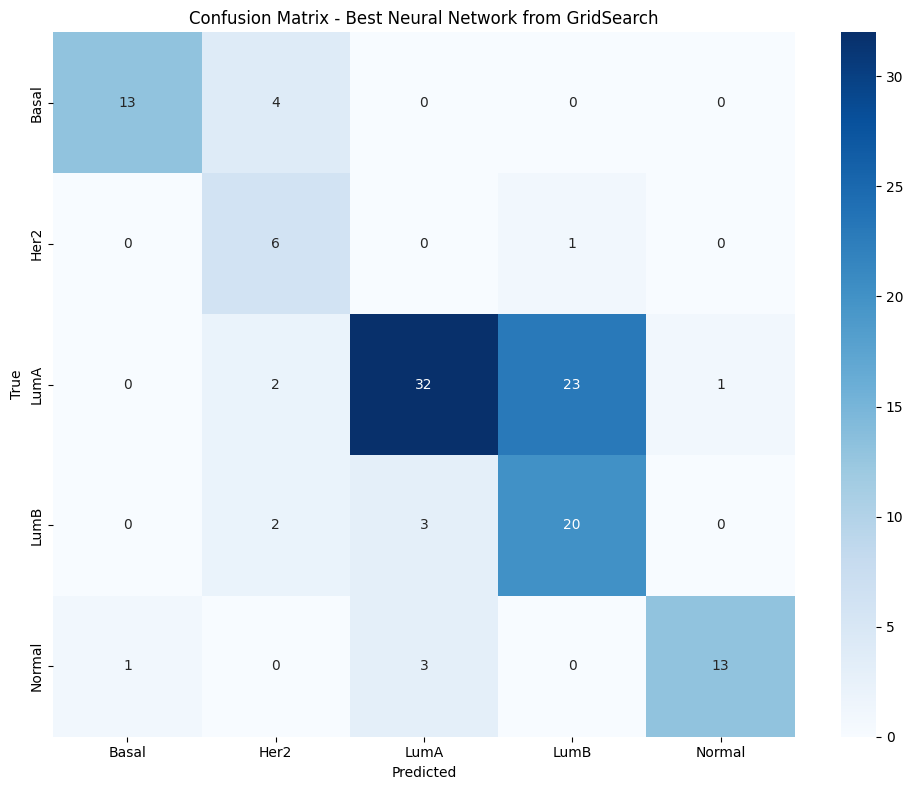


Retraining best model to visualize training history...


d:\Program Files\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


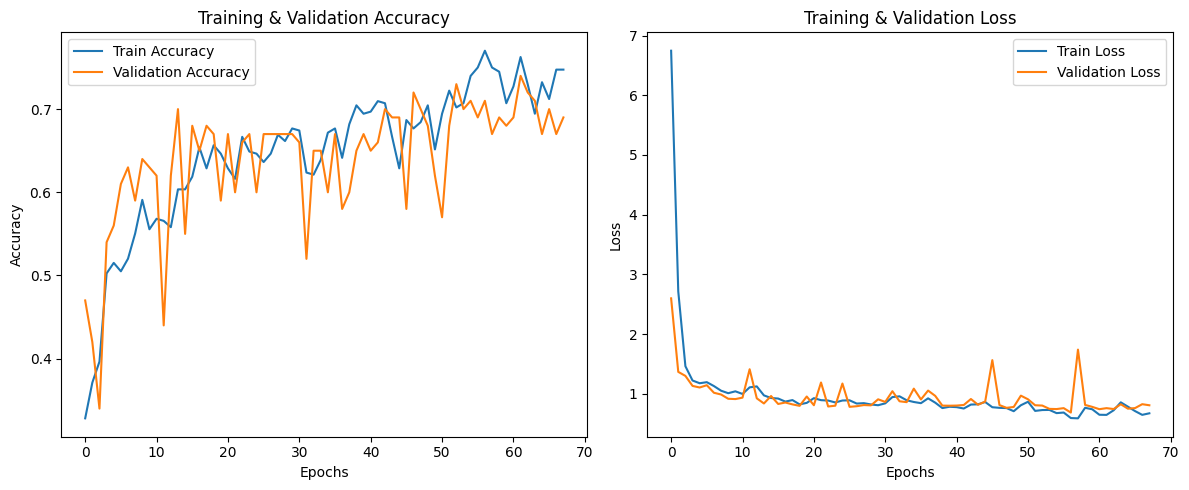

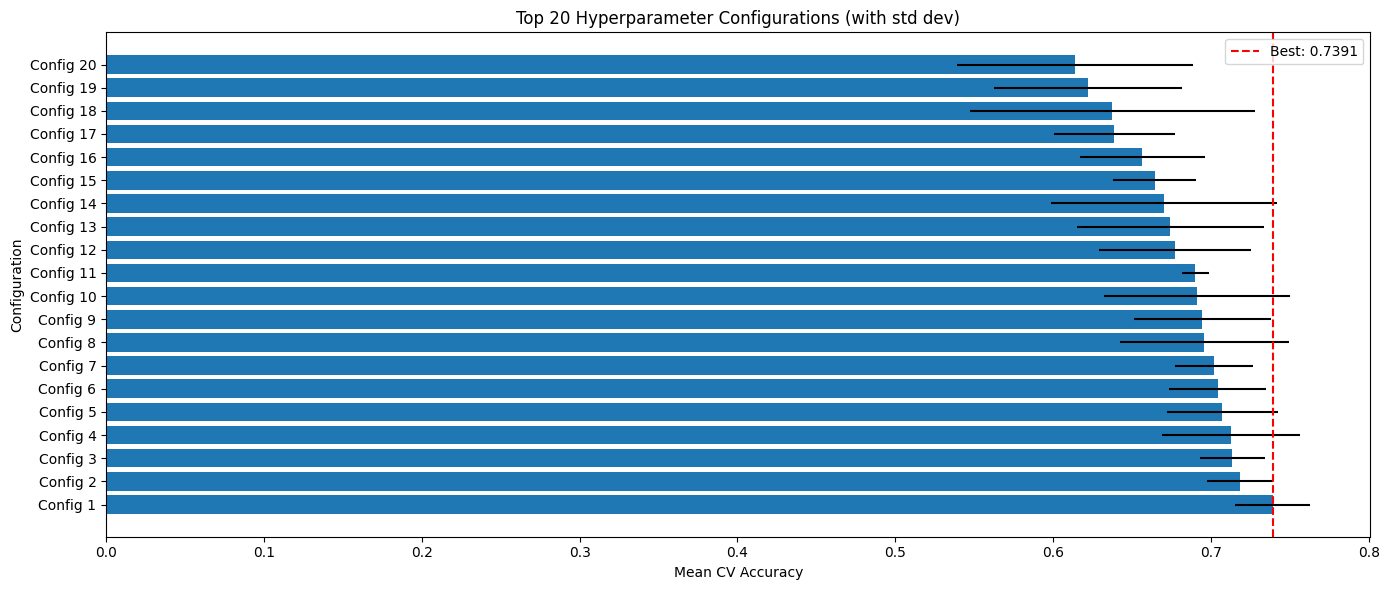


HYPERPARAMETER ANALYSIS:

nn__model__regularization:
  l1_l2: appears 4/10 times in top 10
  l2: appears 4/10 times in top 10
  l1: appears 2/10 times in top 10

nn__model__activation:
  <LeakyReLU name=leaky_re_lu, built=True>: appears 6/10 times in top 10
  tanh: appears 2/10 times in top 10
  relu: appears 2/10 times in top 10

nn__model__learning_rate:
  0.0001: appears 8/10 times in top 10
  0.001: appears 2/10 times in top 10

nn__batch_size:
  16: appears 6/10 times in top 10
  128: appears 2/10 times in top 10
  32: appears 1/10 times in top 10
  64: appears 1/10 times in top 10

nn__model__dropout_rate:
  0.1: appears 5/10 times in top 10
  0.3: appears 2/10 times in top 10
  0.2: appears 2/10 times in top 10
  0.4: appears 1/10 times in top 10


D:\TEMP\ipykernel_6952\1870676457.py:141: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cv_scores, labels=[f'Fold {i+1}' for i in range(n_folds)])


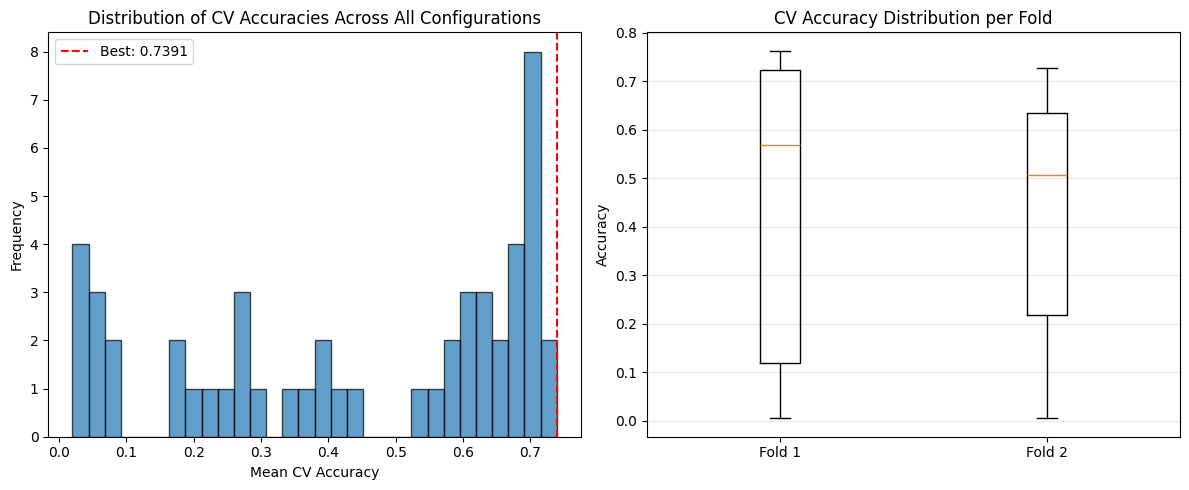


SUMMARY STATISTICS:
Best CV Accuracy: 0.7391
Test Accuracy: 0.6909
Mean CV Accuracy (all configs): 0.4400
Std CV Accuracy (all configs): 0.2512
Min CV Accuracy: 0.0197
Max CV Accuracy: 0.7391


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
from collections import Counter

# Evaluate on test set using best model from grid search
test_acc = grid_search.score(X_test, y_test_enc)
print(f"\nTest Accuracy (Best Neural Network): {test_acc:.4f}")

# Predict using best model
y_pred_classes = grid_search.predict(X_test)

# Classification report
print("\nClassification Report (Best Neural Network):")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_enc, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Best Neural Network from GridSearch')
plt.tight_layout()
plt.show()

print("\nRetraining best model to visualize training history...")

best_params = grid_search.best_params_

meta = {
    "n_features_in_": X_train.shape[1],
    "n_classes_": len(np.unique(y_train_enc))
}

best_model = create_nn(
    meta=meta,
    neurons_layer1=best_params.get('nn__model__neurons_layer1', 256),
    neurons_layer2=best_params.get('nn__model__neurons_layer2', 128),
    dropout_rate=best_params['nn__model__dropout_rate'],
    learning_rate=best_params['nn__model__learning_rate'],
    activation=best_params['nn__model__activation'],
    regularization=best_params['nn__model__regularization']
)

history = best_model.fit(
    X_train, y_train_enc,
    validation_split=0.2,
    epochs=100,
    batch_size=best_params['nn__batch_size'],
    verbose=0,
    callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
)

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# GridSearch Results Visualization
# ------------------------------------------------------------------

results_df = pd.DataFrame(grid_search.cv_results_)

# Plot top 20 configurations
plt.figure(figsize=(14, 6))
top_20 = results_df.nsmallest(20, 'rank_test_score')

plt.barh(range(len(top_20)), top_20['mean_test_score'], xerr=top_20['std_test_score'])
plt.yticks(range(len(top_20)), [f"Config {i+1}" for i in range(len(top_20))])
plt.xlabel('Mean CV Accuracy')
plt.ylabel('Configuration')
plt.title('Top 20 Hyperparameter Configurations (with std dev)')
plt.axvline(x=grid_search.best_score_, color='r', linestyle='--', label=f'Best: {grid_search.best_score_:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# Hyperparameter importance analysis
# ------------------------------------------------------------------

print("\n" + "="*80)
print("HYPERPARAMETER ANALYSIS:")
print("="*80)

top_10_configs = results_df.nsmallest(10, 'rank_test_score')

for param in ['nn__model__regularization', 'nn__model__activation', 
              'nn__model__learning_rate', 'nn__batch_size', 'nn__model__dropout_rate']:
    print(f"\n{param}:")
    param_values = [config[param] for config in top_10_configs['params']]
    counts = Counter(param_values)
    for value, count in counts.most_common():
        print(f"  {value}: appears {count}/10 times in top 10")

# ------------------------------------------------------------------
# CV Accuracy Distribution
# ------------------------------------------------------------------

plt.figure(figsize=(12, 5))

# Histogram of all CV accuracies
plt.subplot(1, 2, 1)
plt.hist(results_df['mean_test_score'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=grid_search.best_score_, color='r', linestyle='--', 
            label=f'Best: {grid_search.best_score_:.4f}')
plt.xlabel('Mean CV Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of CV Accuracies Across All Configurations')
plt.legend()

# Box plot (adjust to number of folds)
plt.subplot(1, 2, 2)
n_folds = grid_search.cv  # dynamically use actual folds
cv_scores = [results_df[f'split{i}_test_score'] for i in range(n_folds)]
plt.boxplot(cv_scores, labels=[f'Fold {i+1}' for i in range(n_folds)])
plt.ylabel('Accuracy')
plt.title('CV Accuracy Distribution per Fold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# Summary statistics
# ------------------------------------------------------------------

print("\n" + "="*80)
print("SUMMARY STATISTICS:")
print("="*80)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Mean CV Accuracy (all configs): {results_df['mean_test_score'].mean():.4f}")
print(f"Std CV Accuracy (all configs): {results_df['mean_test_score'].std():.4f}")
print(f"Min CV Accuracy: {results_df['mean_test_score'].min():.4f}")
print(f"Max CV Accuracy: {results_df['mean_test_score'].max():.4f}")


In [ ]:
rf = best_model.named_steps['rf']

if len(original_feature_names) != len(rf.feature_importances_):
    print(f"Warning: Number of feature names ({len(original_feature_names)}) doesn't match number of features used ({len(rf.feature_importances_)})")
    # Use generic names if there's a mismatch
    feature_names = [f'Feature {i}' for i in range(len(rf.feature_importances_))]
else:
    feature_names = original_feature_names

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Display top 20 features
top_n = 20
plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importance.head(top_n), x='Importance', y='Feature')
plt.title(f'Top {top_n} Most Important Features')
plt.tight_layout()
plt.show()

print("Top 20 features by importance:")
print(feature_importance['Feature'].head(20).tolist())

AttributeError: 'Sequential' object has no attribute 'named_steps'